In [1]:
import tushare as ts
import seaborn as sns
import keras

Using TensorFlow backend.
/Users/greenwood/Study/Program/Project/citi cup/repo/model/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/greenwood/Study/Program/Project/citi cup/repo/model/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/greenwood/Study/Program/Project/citi cup/repo/model/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)

In [2]:
ts.set_token('53cd3b985c649c978160c6ec04bce24f4fbd2ebcb4673e8f2fba9a43')

In [3]:
pro = ts.pro_api()

sz1 = pro.daily(ts_code='000001.SZ', start_date='20150817', end_date='20190817')

/Users/greenwood/Study/Program/Project/citi cup/repo/model/venv/lib/python3.7/site-packages/tushare/util/upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [4]:
sz1.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20190816,15.09,15.14,14.78,14.90,14.94,-0.04,-0.2677,986902.93,1474900.257
1,000001.SZ,20190815,14.64,14.96,14.60,14.94,14.97,-0.03,-0.2004,897376.26,1333117.725
2,000001.SZ,20190814,15.14,15.22,14.80,14.97,14.89,0.08,0.5373,1360546.54,2038261.151
3,000001.SZ,20190813,15.00,15.08,14.74,14.89,15.12,-0.23,-1.5212,1293736.44,1925835.288
4,000001.SZ,20190812,14.61,15.12,14.60,15.12,14.52,0.60,4.1322,2733425.47,4084497.902


In [5]:
sz1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 11 columns):
ts_code       976 non-null object
trade_date    976 non-null object
open          976 non-null float64
high          976 non-null float64
low           976 non-null float64
close         976 non-null float64
pre_close     976 non-null float64
change        976 non-null float64
pct_chg       976 non-null float64
vol           976 non-null float64
amount        976 non-null float64
dtypes: float64(9), object(2)
memory usage: 84.0+ KB


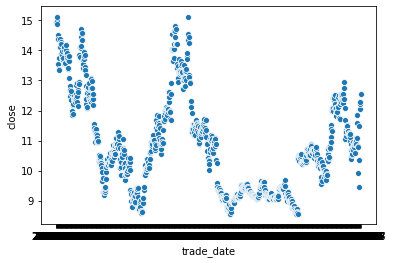

In [6]:
sns.scatterplot(x=sz1['trade_date'], y=sz1['close'])